In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gdal
from sentinelhub import SHConfig, BBox, WmsRequest, CRS, DataSource, MimeType
from landsatxplore.earthexplorer import EarthExplorer

import subprocess

import SatelliteUtils
from SatelliteUtils import plot_map

gdal.UseExceptions()

# Sentinel 2

## Download two satellite images that cover Kyiv

In [2]:
bboxA = BBox(bbox=[300000.000, 5590350.000, 409800.000, 5490240.000], crs=CRS.UTM_36N)
bboxB = BBox(bbox=[300000.000, 5700000.000, 409800.000, 5590360.000], crs=CRS.UTM_36N)

sentinel_folder = "data/Sentinel/"

config = SHConfig()

sentinel_requestA = WmsRequest(
    data_source=DataSource.SENTINEL2_L2A,
    data_folder=sentinel_folder,
    layer='BANDS-S2-L2A',
    bbox=bboxA,
    time='2019-08-21 09:06:28',    
    width=1500,
    image_format=MimeType.TIFF_d32f,
    config=config)

sentinel_requestB = WmsRequest(
    data_source=DataSource.SENTINEL2_L2A,
    data_folder=sentinel_folder,
    layer='BANDS-S2-L2A',
    bbox=bboxB,
    time='2019-08-21 09:06:13',
    width=1500,    
    image_format=MimeType.TIFF_d32f,
    config=config)

sentinel_requestA.save_data()
sentinel_requestB.save_data()

## Concantenate Kyiv's datasets

In [3]:
aPath = sentinel_folder + sentinel_requestA.get_filename_list()[0]
bPath = sentinel_folder + sentinel_requestB.get_filename_list()[0]
vrt = gdal.BuildVRT(f"{sentinel_folder}/Kyiv.vrt", [aPath, bPath])

In [4]:
sentinel = gdal.Translate(f"{sentinel_folder}/Sentinel.tiff", vrt)

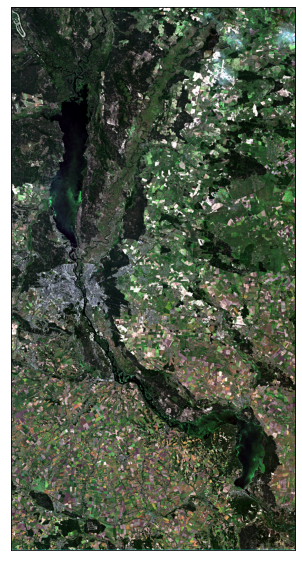

In [5]:
plot_map(sentinel, [3,2,1])

## Reproject to EPSG:4326

In [6]:
sentinel4326 = gdal.Warp(f"{sentinel_folder}/Sentinel4326.tiff", sentinel, dstSRS="EPSG:4326")

## Crop to real Kyiv bounds

In [7]:
sentinelKyiv = gdal.Warp(f"{sentinel_folder}/Kyiv.tiff", sentinel4326, cutlineDSName="data/KyivRegionShape/Kyiv_regions.shp", cropToCutline=True)

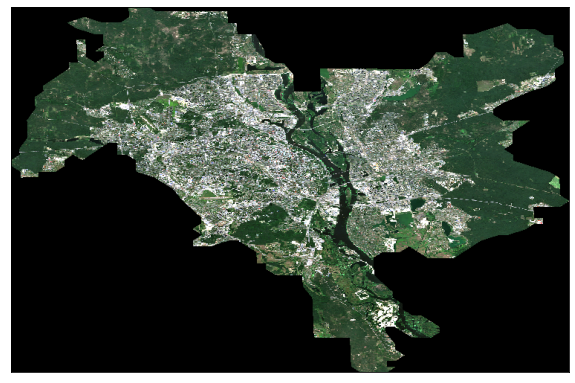

In [8]:
plot_map(sentinelKyiv, [3,2,1])

# Landsat 8

## Load Landsat-8 data via landsatexprl

In [9]:
scene_id = 'LC08_L1TP_182025_20190830_20190903_01_T1'
landsat_folder = "data/Landsat"

username = SatelliteUtils.get_earth_explorer_username()
password = SatelliteUtils.get_earth_explorer_password()
#ee = EarthExplorer(username, password)

#ee.download(scene_id=scene_id, output_dir=landsat_folder)

#SatelliteUtils.untar(f"{landsat_folder}/{scene_id}.tar.gz", f"{landsat_folder}/{scene_id}")

## Resize panchromatic chanell to 30m

In [23]:
band8 = f"{landsat_folder}/{scene_id}/{scene_id}_B8.TIF"
panchro30 = gdal.Translate(f"{landsat_folder}/panchromatic30.tiff", band8, xRes=30, yRes=30)
panchro30.FlushCache()
panchro30 = None

## Merge in one RGB chanells

In [11]:
def merge_channels(outPath, spectral_paths):
    call = ["gdal_merge.py", "-o", outPath, "-separate"]
    for chanell in spectral_paths:
        call.append(chanell)
    subprocess.run(call, capture_output=True)

In [12]:
spectrals = [f"{landsat_folder}/{scene_id}/{scene_id}_B{i}.TIF" for i in [4,3,2]]    
merge_channels(f"{landsat_folder}/spectral30.tiff", spectrals)

## Resize RGB to 60m

In [13]:
spectral60 = gdal.Translate(f"{landsat_folder}/spectral60.tiff", f"{landsat_folder}/spectral30.tiff", xRes=60, yRes=60)

## Pansharpening

In [14]:
def pansharp(panchroPath, spectralPath, outPath, method='cubic'):
    subprocess.run(["gdal_pansharpen.py", panchroPath, spectralPath, outPath, "-r", method])

In [15]:
def mse(ideal, predicted):
    return np.power(ideal-predicted, 2).mean()

def squared(ideal, predicted):
    return 1 - np.var(ideal.flatten())/mse(ideal, predicted)

def add_metrics_to_list(metric_func, rIdeal, gIdeal, bIdeal, rPred, gPred, bPred, rList, gList, bList):
    rList.append(metric_func(rIdeal, rPred))
    gList.append(metric_func(gIdeal, gPred))
    bList.append(metric_func(bIdeal, bPred))
    
    return rList, gList, bList

In [24]:
methods = ['nearest','bilinear','cubic','cubicspline','lanczos','average']

r_MSE = []
r_squared = []
g_MSE = []
g_squared = []
b_MSE = []
b_squared = []

spectral30 = gdal.Open(f"{landsat_folder}/spectral30.tiff")

rIdeal = spectral30.GetRasterBand(1).ReadAsArray()
gIdeal = spectral30.GetRasterBand(2).ReadAsArray()
bIdeal = spectral30.GetRasterBand(3).ReadAsArray()

pansh_folder = "data/Pansharpen/"

for method in methods:
    path = f"{pansh_folder}/{method}.tiff"
    
    pansharp(f"{landsat_folder}/panchromatic30.tiff", f"{landsat_folder}/spectral60.tiff", path, method)
    
    temp = gdal.Open(path)
    
    rPan = temp.GetRasterBand(1).ReadAsArray()
    gPan = temp.GetRasterBand(2).ReadAsArray()
    bPan = temp.GetRasterBand(3).ReadAsArray()

    r_MSE, g_MSE, b_MSE = add_metrics_to_list(mse, rIdeal, gIdeal, bIdeal, rPan, \
                                                       gPan, bPan, r_MSE,
                                                       g_MSE, b_MSE)
    
    #r_squared, g_squared, b_squared = add_metrics_to_list(squared, rIdeal, gIdeal, bIdeal, rPan, \
    #                                                   gPan, bPan, r_squared,
    #                                                   g_squared, b_squared)

    
metrics = pd.DataFrame({
    'method':methods,
    'MSE_R':r_MSE,
    'MSE_G':g_MSE,
    'MSE_B':b_MSE#,
    #'Squared_R':r_squared,
    #'Squared_G':g_squared,
    #'Squared_B':b_squared
})

In [25]:
metrics

,method,MSE_R,MSE_G,MSE_B
0,nearest,19387.850168,19490.232953,19532.549112
1,bilinear,19612.855515,19527.572646,19497.624736
2,cubic,19591.223508,19543.039431,19551.624701
3,cubicspline,19554.931209,19507.776009,19439.105554
4,lanczos,19557.514035,19546.634261,19565.523777
5,average,19559.428655,19530.718833,19529.369351


In [26]:
mean_mse = metrics[["MSE_R", "MSE_G", "MSE_B"]].mean(axis=1)
mean_mse

0    19470.210744
1    19546.017632
2    19561.962547
3    19500.604257
4    19556.557358
5    19539.838946
dtype: float64

## Plot best pansharping image
[Landsat plot expamples](https://earthpy.readthedocs.io/en/latest/gallery_vignettes/plot_rgb.html)

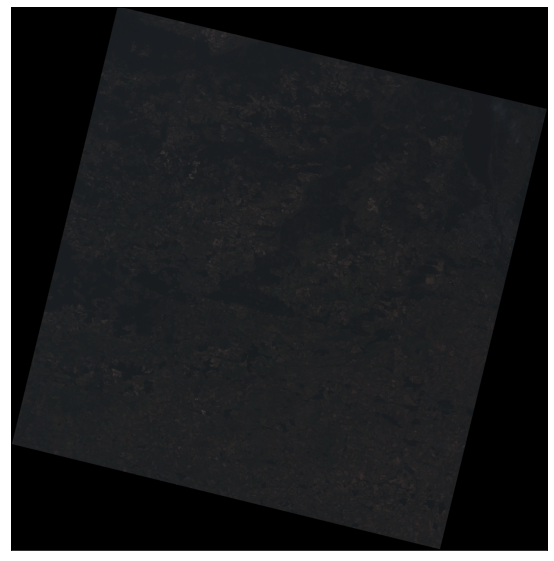

In [27]:
best_method = metrics.iloc[np.argmin(mean_mse)]['method']
best = gdal.Open(f"{pansh_folder}/{best_method}.tiff")

plot_map(best, stretch=False)

In [28]:
import skimage.exposure 

def plot_landsat_pretty(ds, xStart, xStop, yStart, yStop):
    data_red = ds.GetRasterBand(1).ReadAsArray()[xStart:xStop, yStart:yStop]
    data_grn = ds.GetRasterBand(2).ReadAsArray()[xStart:xStop, yStart:yStop]
    data_blu = ds.GetRasterBand(3).ReadAsArray()[xStart:xStop, yStart:yStop]

    eq_red = skimage.exposure.equalize_hist(data_red)
    eq_grn = skimage.exposure.equalize_hist(data_grn)
    eq_blu = skimage.exposure.equalize_hist(data_blu)

    temp = np.max([np.max(eq_red), np.max(eq_grn), np.max(eq_blu)])    

    eqh = np.zeros((yStop - yStart, xStop - xStart, 3))

    eqh[:,:,0] = eq_red/temp
    eqh[:,:,1] = eq_grn/temp
    eqh[:,:,2] = eq_blu/temp

    plt.imshow(eqh)

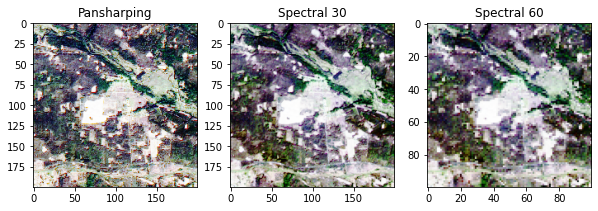

In [29]:
plt.figure(figsize=(10,10))

ax = plt.subplot(1,3,1)
ax.title.set_text("Pansharping")
plot_landsat_pretty(best, 2000, 2200, 3300, 3500)

ax = plt.subplot(1,3,2)
ax.title.set_text("Spectral 30")
plot_landsat_pretty(spectral30, 2000, 2200, 3300, 3500)

ax = plt.subplot(1,3,3)
ax.title.set_text("Spectral 60")
plot_landsat_pretty(spectral60, 1000, 1100, 1650, 1750)